In [59]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [60]:
# !sudo apt install git-lfs
# !git lfs version
!ls ml
!rm -rf ml
!ls ml
!mkdir ml
# !git init
# !git lfs install
!git clone https://github.com/kokoichi206/ml.git
!cd ml  # cd is not working
!mv ml/saka .

!ls saka | wc

akimoto  akimoto-gan  akimoto-nlp  README.md  web
ls: cannot access 'ml': No such file or directory
Cloning into 'ml'...
remote: Enumerating objects: 10414, done.
remote: Counting objects: 100% (78/78), done.
remote: Compressing objects: 100% (57/57), done.
remote: Total 10414 (delta 25), reused 69 (delta 16), pack-reused 10336
Receiving objects: 100% (10414/10414), 566.11 MiB | 16.39 MiB/s, done.
Resolving deltas: 100% (93/93), done.
Checking out files: 100% (10267/10267), done.
mv: cannot stat 'ml/saka': No such file or directory
     84     168    1233


In [61]:
import glob

files = glob.glob('saka/*/*.jpg')
len(files)

4268

In [62]:
BASE_DIR = "/content/drive/MyDrive/Colab Notebooks/akimoto/gan_saka"

In [63]:
import matplotlib.pyplot as plt
import numpy as np
import tqdm
import glob

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.datasets as dset
import torchvision.utils as vutils

In [64]:
import argparse

parser = argparse.ArgumentParser()
parser.add_argument("--n_epoch", type=int, default=500)
parser.add_argument("--batch_size", type=int, default=64)
parser.add_argument("--lr_g", type=float, default=1e-4)
parser.add_argument("--lr_d", type=float, default=4e-4)
parser.add_argument("--nch_g", type=int, default=64)
parser.add_argument("--nch_d", type=int, default=64)
parser.add_argument("--z_dim", type=int, default=100) # noize dimension
parser.add_argument("--beta1", type=float, default=0.0) # for Adam optimizer
opt = parser.parse_args(args=[])

In [65]:
class SelfAttention(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        out_channels = in_channels // 8
        self.fx_1x1 = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.gx_1x1 = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.hx_1x1 = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim=-2)

    def forward(self, x):
        B, C, H, W = x.size()
        fx = self.fx_1x1(x).view(B, -1, H * W).permute(0, 2, 1) # 転置
        gx = self.gx_1x1(x).view(B, -1, H * W)
        hx = self.hx_1x1(x).view(B, -1, H * W)
        s_mtx = torch.bmm(fx, gx)   # ミニバッチ毎に行列積を計算
        attention = self.softmax(s_mtx)
        o = torch.bmm(hx, attention)    # attention で重み付けられた入力が返ってくる
        o = o.view(B, -1, H, W)
        out = x + self.gamma * o
        return out

In [66]:
from torch.utils.data import Dataset
from PIL import Image

class ImageDataset(Dataset):
    def __init__(self, transform=None):
        super().__init__()
        self.file_list = glob.glob("saka/*/*.jpg")
        self.transform = transform
    
    def __getitem__(self, index):
        # If transform exists, do pre_process
        if self.transform is not None:
            img = self.transform(Image.open(self.file_list[index]))
        else:
            img = Image.open(self.file_list[index])
        return img

    def __len__(self):
        return len(self.file_list)


In [67]:
class Generator(nn.Module):
    def __init__(self, self_attention, z_dim=100, ngf=64, nc=3):   # nc=1 for black-and-white images
        super().__init__()
        self.convt1 = self.conv_trans_layers(z_dim, 8*ngf, 4, 1, 0, True)
        self.convt2 = self.conv_trans_layers(8*ngf, 4*ngf, 4, 2, 1, True)
        self.convt3 = self.conv_trans_layers(4*ngf, 2*ngf, 4, 2, 1, True)
        self.attention1 = self_attention(2 * ngf)
        self.convt4 = self.conv_trans_layers(2*ngf, ngf, 4, 2, 1, True)
        self.attention2 = self_attention(ngf)
        self.convt5 = nn.Sequential(
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1),
            nn.Tanh()
        )

    @staticmethod
    def conv_trans_layers(in_channels, out_channels, kernel_size, stride, padding, has_norm):
        layers = [nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding))]
        if has_norm:
            layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.ReLU(inplace=True))
        net = nn.Sequential(*layers)
        return net

    def forward(self, x):
        out = self.convt1(x)
        out = self.convt2(out)
        out = self.convt3(out)
        out = self.attention1(out)
        out = self.convt4(out)
        out = self.attention2(out)
        out = self.convt5(out)
        return out


In [68]:
class Discriminator(nn.Module):
    def __init__(self, self_attention, nc=3, ndf=64):
        super().__init__()
        self.conv1 = self.conv_layers(nc, ndf)
        self.conv2 = self.conv_layers(ndf, 2*ndf)
        self.conv3 = self.conv_layers(2*ndf, 4*ndf)
        self.attention1 = self_attention(4 * ndf)
        self.conv4 = self.conv_layers(4*ndf, 8*ndf)
        self.attention2 = self_attention(8 * ndf)
        self.conv5 = nn.Conv2d(8 * ndf, 1, 4)

    @staticmethod
    def conv_layers(in_channels, out_channels, kernel_size=4, stride=2, padding=2,
                    has_batch_norm=False):
        layers = [nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding))]
        if has_batch_norm:
            layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.LeakyReLU(0.1, inplace=True))
        net = nn.Sequential(*layers)
        return net

    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.attention1(out)
        out = self.conv4(out)
        out = self.attention2(out)
        out = self.conv5(out)
        return out


In [69]:
def weights_init(m):
    # m means model
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)   # initialize using normal distribution
    elif classname.find("BatchNorm") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)   # initialize using normal distribution
        nn.init.constant_(m.bias.data, 0)


In [70]:
import torchvision.transforms as transforms
transform = transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize((0.5, ), (0.5, ))
])

In [71]:
dataset = ImageDataset(transform=transform)

In [72]:
len(dataset)

4268

In [73]:
dataloader = DataLoader(dataset=dataset, batch_size=opt.batch_size, shuffle=True)

In [74]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [75]:
netG = Generator(SelfAttention, z_dim=opt.z_dim, ngf=opt.nch_g).to(device)
netG.apply(weights_init)
print(netG)

netD = Discriminator(SelfAttention, nc=3, ndf=opt.nch_d).to(device)
netD.apply(weights_init)
print(netD)

Generator(
  (convt1): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (convt2): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (convt3): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (attention1): SelfAttention(
    (fx_1x1): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
    (gx_1x1): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
    (hx_1x1): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
    (softmax): Softmax(dim=-2)
  )
  (convt4): Sequential(
    (0): ConvTranspose2

In [76]:
optimizerG = optim.Adam(netG.parameters(), lr=opt.lr_g, betas=(opt.beta1, 0.999), weight_decay=1e-5)
optimizerD = optim.Adam(netD.parameters(), lr=opt.lr_d, betas=(opt.beta1, 0.999), weight_decay=1e-5)

In [77]:
def save_params(file_path, epoch, netD, netG):
    torch.save(
        netG.state_dict(),
        file_path + "/g_{:04d}.pth".format(epoch)
    )
    torch.save(
        netD.state_dict(),
        file_path + "/d_{:04d}.pth".format(epoch)
    )


In [78]:
import os

model_name = "SAGAN"
f_path_result = f"{BASE_DIR}/result/{model_name}"
f_path_params = f"{BASE_DIR}/params/{model_name}"

os.makedirs(f_path_result, exist_ok=True)
os.makedirs(f_path_params, exist_ok=True)

In [79]:
def hinge(x):
    relu = torch.nn.ReLU()
    return relu(1.0 - x)

def hinge_loss(output, is_real=True):
    sign = 1 if is_real else -1
    return torch.mean(hinge(sign * output))

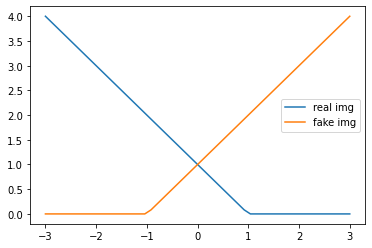

In [80]:
import matplotlib.pyplot as plt

x = torch.linspace(-3, 3, steps=50)
y = hinge(x)
# print(y)
# print(y.cpu().numpy())
plt.plot(x.cpu().numpy(), y.cpu().numpy(), label="real img")
y = hinge(-x)
plt.plot(x.cpu().numpy(), y.cpu().numpy(), label="fake img")
plt.legend()
plt.show()

In [81]:
lossesD = []
lossesG = []
raw_lossesD = []
raw_lossesG = []
relu = torch.nn.ReLU()
for epoch in range(opt.n_epoch):
    running_lossD = 0.0
    running_lossG = 0.0
    for i, real_imgs in enumerate(tqdm.tqdm(dataloader, position=0)):
        real_imgs = real_imgs.to(device)
        batch_size = real_imgs.size()[0]
        noise = torch.randn(batch_size, opt.z_dim, 1, 1).to(device)

        # Train Disc
        netD.zero_grad()
        output = netD(real_imgs)
        lossD_real = hinge_loss(output)

        fake_imgs = netG(noise)
        output = netD(fake_imgs.detach())   # 識別器の訓練の際には、生成器の方は更新しないので、detach
        lossD_fake = hinge_loss(output, False)

        lossD = lossD_real + lossD_fake
        lossD.backward()
        optimizerD.step()

        # Train Gen
        netG.zero_grad()
        output = netD(fake_imgs)
        lossG = -torch.mean(output)
        lossG.backward()
        optimizerG.step()

        # save losses
        running_lossD += lossD.item()
        running_lossG += lossG.item()
        raw_lossesD.append(lossD.item())
        raw_lossesG.append(lossG.item())
    
    running_lossD /= len(dataloader)
    running_lossG /= len(dataloader)
    print("epoch: {}, lossD: {}, lossG: {}".format(epoch, running_lossD, running_lossG))
    lossesD.append(running_lossD)
    lossesG.append(running_lossG)

    # show fake imgs
    grid_imgs = vutils.make_grid(fake_imgs[:25].detach() + 0.5, nrow=5)
    grid_imgs_arr = grid_imgs.cpu().numpy()
    plt.imshow(np.transpose(grid_imgs_arr, (1, 2, 0)))
    plt.show()

    # save imgs and params
    vutils.save_image(fake_imgs + 0.5, f_path_result + "/{:04d}.jpg".format(epoch))
    save_params(f_path_params, epoch, netD, netG)


Output hidden; open in https://colab.research.google.com to view.